In [1]:
# based on: https://www.kaggle.com/mlwhiz/multiclass-text-classification-pytorch/notebook
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
embed_size = 200 # how big is each word vector
max_features = 28000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 120 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

In [4]:
df_purged = pd.read_pickle("data/Movies_and_TV_5_prep_tokenized.pkl")

In [5]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(df_purged['reviewText'], df_purged['label'], stratify=df_purged['label'], test_size=0.80)

In [6]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (681684,)
Test shape :  (2726737,)


In [9]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(list(train_X))
test_X = tokenizer.texts_to_sequences(list(test_X))

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [12]:
np.save("data/train_X.npy", train_X)
np.save("data/test_X.npy", test_X)

In [13]:
np.save("data/train_y.npy", train_y.values)
np.save("data/test_y.npy", test_y.values)

In [14]:
train_X = np.load("data/train_X.npy")
train_y = np.load("data/train_y.npy")

In [15]:
train_X.shape

(681684, 120)

In [16]:
class LSTM(nn.Module):
    
    def __init__(self):
        super(LSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = 3
        self.embedding = nn.Embedding(max_features, embed_size)
        # self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, batch_first=True)
        self.linear = nn.Linear(self.hidden_size , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        conc = self.relu(self.linear(h_lstm[:,-1,:]))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [17]:
model = LSTM()

In [18]:
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.cuda()

LSTM(
  (embedding): Embedding(28000, 200)
  (lstm): LSTM(200, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=64, out_features=3, bias=True)
)

In [19]:
# Load train and test in CUDA Memory
x_train = torch.tensor(train_X[0:30000], dtype=torch.long).cuda()
y_train = torch.tensor(train_y[0:30000], dtype=torch.long).cuda()

x_cv = torch.tensor(train_X[30000:35000], dtype=torch.long).cuda()
y_cv = torch.tensor(train_y[30000:35000], dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

In [20]:
# TODO
test_y = train_y[30000:35000]

In [21]:
# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

In [22]:
train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),3))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

C:\Users\kajud\AppData\Local\Temp/ipykernel_18136/2117959004.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/5 	 loss=385.0452 	 val_loss=299.6609  	 val_acc=0.7972  	 time=2.11s
Epoch 2/5 	 loss=296.4223 	 val_loss=278.6196  	 val_acc=0.7998  	 time=1.45s
Epoch 3/5 	 loss=265.6129 	 val_loss=261.1003  	 val_acc=0.8092  	 time=1.46s
Epoch 4/5 	 loss=241.9887 	 val_loss=243.1193  	 val_acc=0.8236  	 time=1.46s
Epoch 5/5 	 loss=221.0437 	 val_loss=239.1951  	 val_acc=0.8232  	 time=1.46s


In [23]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(6,6))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

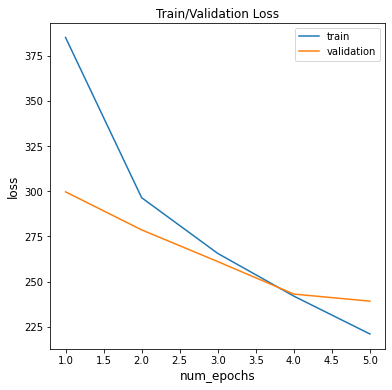

In [24]:
plot_graph(n_epochs)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

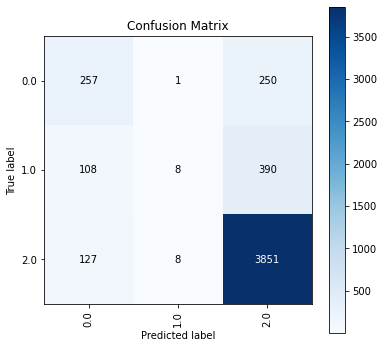

In [25]:
import scikitplot as skplt
y_true = [x for x in test_y]
y_pred = [x for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(6,6),x_tick_rotation=90)